# LDA - Sentences - Iterative filtering - Run 1

Note: 

This notebook loads the models from f1000_LDA_Sentence_Run_1 and returns "f1000_tokenized_LDA_sentence_2.tsv", which is the input for "f1000_LDA_Sentence_Run" with ITER = 2.

## Configuration

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import re
from collections import defaultdict  # For word frequency
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm
import IPython #for HTML viz

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from peertax.LDA_Diagnostic import LDA_Conv, LDA_Scores

## Model selection

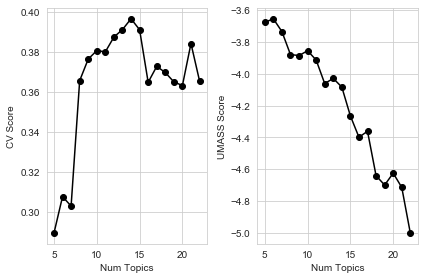

In [2]:
base_pth = './f1000_LDA_Sentence_Run_1/'
cv_arr, um_arr = LDA_Scores(base_pth)

plt.subplot(1,2,1)
plt.plot(cv_arr[:,0],cv_arr[:,1],'ko-')
plt.ylabel("CV Score")
plt.xlabel("Num Topics")

plt.subplot(1,2,2)
plt.plot(um_arr[:,0],um_arr[:,1],'ko-')
plt.ylabel("UMASS Score")
plt.xlabel("Num Topics")
plt.tight_layout()

Best model (highest CV Score) is Model_14.

Load corpus from Run_1 and Model_14.

In [3]:
num_topics = '14'
model_no = 'Model_' + num_topics
model_pth = base_pth + model_no

# Load sentence data from tsv
path_load_tsv = '../pickles/f1000_tokenized_LDA_sentence_1.tsv'
df = pd.read_csv(path_load_tsv,sep='\t',quoting=csv.QUOTE_NONE)
df.drop(columns=['Unnamed: 0'],inplace=True)
df['token'] = df['token'].str.split(',')

# Create Corpus
texts = df['token']
#Load Model
lda_model = gensim.models.ldamodel.LdaModel.load(model_pth)
id2word = gensim.corpora.Dictionary.load(model_pth + '.id2word')
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print('Total number of sentences: %s' % len(corpus))

INFO - 12:49:47: loading LdaModel object from ./f1000_LDA_Sentence_Run_1/Model_14
INFO - 12:49:47: loading expElogbeta from ./f1000_LDA_Sentence_Run_1/Model_14.expElogbeta.npy with mmap=None
INFO - 12:49:47: setting ignored attribute state to None
INFO - 12:49:47: setting ignored attribute dispatcher to None
INFO - 12:49:47: setting ignored attribute id2word to None
INFO - 12:49:47: loaded ./f1000_LDA_Sentence_Run_1/Model_14
INFO - 12:49:47: loading LdaState object from ./f1000_LDA_Sentence_Run_1/Model_14.state
INFO - 12:49:47: loaded ./f1000_LDA_Sentence_Run_1/Model_14.state
INFO - 12:49:47: loading Dictionary object from ./f1000_LDA_Sentence_Run_1/Model_14.id2word
INFO - 12:49:47: loaded ./f1000_LDA_Sentence_Run_1/Model_14.id2word


Total number of sentences: 78381


Check convergence.

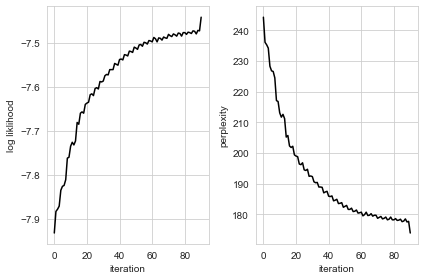

In [4]:
iter_no, perplexity, likelihood = LDA_Conv(base_pth,num_topics)
plt.subplot(1,2,1)
plt.plot(iter_no,likelihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")

plt.subplot(1,2,2)
plt.plot(iter_no,perplexity,c="black")
plt.ylabel("perplexity")
plt.xlabel("iteration")
plt.tight_layout()

Show topic visualization.

In [5]:
IPython.display.HTML(filename=model_pth+'.html')

Show topic contents (text).

In [6]:
lda_model.show_topics(num_topics=25, num_words=10, log=False, formatted=True)

[(0,
  '0.042*"use" + 0.032*"model" + 0.029*"method" + 0.027*"describe" + 0.019*"package" + 0.019*"author" + 0.017*"datum" + 0.016*"available" + 0.014*"provide" + 0.012*"software"'),
 (1,
  '0.048*"different" + 0.025*"value" + 0.023*"difference" + 0.016*"group" + 0.015*"mean" + 0.015*"effect" + 0.014*"time" + 0.010*"datum" + 0.009*"age" + 0.009*"result"'),
 (2,
  '0.026*"datum" + 0.021*"tool" + 0.013*"provide" + 0.012*"user" + 0.011*"system" + 0.010*"research" + 0.009*"resource" + 0.009*"researcher" + 0.009*"useful" + 0.009*"new"'),
 (3,
  '0.040*"section" + 0.034*"sentence" + 0.030*"paragraph" + 0.028*"page" + 0.028*"introduction" + 0.027*"mention" + 0.027*"author" + 0.025*"abstract" + 0.019*"refer" + 0.019*"text"'),
 (4,
  '0.014*"author" + 0.013*"protein" + 0.010*"increase" + 0.010*"change" + 0.009*"activity" + 0.007*"high" + 0.007*"know" + 0.006*"rate" + 0.005*"detect" + 0.005*"signal"'),
 (5,
  '0.055*"study" + 0.052*"analysis" + 0.033*"datum" + 0.029*"author" + 0.015*"test" + 0.0

Manually select the topics to be discarded (because they are full of technical jargon).

In [8]:
bad_topics = [4]

Assign topics to initial dataframe.

In [9]:
topics = [max(lda_model.get_document_topics(row),key=itemgetter(1))[0] for row in tqdm(corpus)]

In [10]:
df['topics'] = topics
df.head()

,manuscript_ID,review_ID,sentences,token,topics
0,10.12688/f1000research.1-1.v1,10.5256/f1000research.50.r101,"However, I am sure there are some sections whe...","[sure, section, reader, like, information, adj...",5
1,10.12688/f1000research.1-1.v1,10.5256/f1000research.50.r100,This paper has a number of serious flaws.,"[paper, number, flaw]",13
2,10.12688/f1000research.1-1.v1,10.5256/f1000research.50.r100,a) The literature is quoted selectively and is...,"[literature, quote, selectively, issue, oversi...",11
3,10.12688/f1000research.1-1.v1,10.5256/f1000research.50.r100,For example it doesn t reference articles such...,"[example, doesn, reference, article]",10
4,10.12688/f1000research.1-1.v1,10.5256/f1000research.50.r100,A single citation (a paper by the same author)...,"[single, citation, paper, author, claim, provide]",10


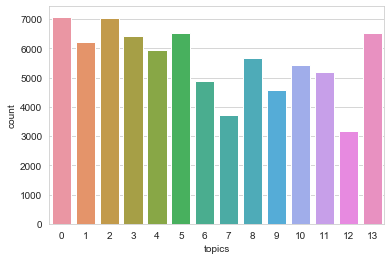

In [11]:
sns.countplot(x='topics',data=df);

Filter topics.

In [12]:
df_filter = df[~df['topics'].isin(bad_topics)].copy()
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72451 entries, 0 to 78380
Data columns (total 5 columns):
manuscript_ID    72451 non-null object
review_ID        72451 non-null object
sentences        72451 non-null object
token            72451 non-null object
topics           72451 non-null int64
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


Save to tsv.

In [13]:
path_save_tsv = "../pickles/f1000_tokenized_LDA_sentence_2.tsv"
df_filter['token'] = df_filter['token'].str.join(',')
df_filter.to_csv(path_save_tsv,sep='\t',quoting=csv.QUOTE_NONE)